# The workflow for Kalberla et.al (2022)'s mistake

KH Yuen (UW Madison, kyuen2@wisc.edu)
Feb 07, 2022, using `Julia v1.5.0`

## Background information of "velocity caustics debate"

Under the formalism of Yuen et.al (VDA, 2021, ApJ, 910,2, 161), for a given spectroscopic channel map $p=p({\bf X},v)$, where ${\bf X} \in \mathcal{R}^2$ is the spatial vector and $v$ is the velocity axis, $p_d$ and $p_v$ are given by:
$$
\begin{align}
  p_v &= p - \left( \langle pI\rangle-\langle p\rangle\langle I \rangle\right)\frac{I-\langle I\rangle}{\sigma_I^2}\\
  p_d &= \left( \langle pI\rangle-\langle p\rangle\langle I \rangle\right)\frac{I-\langle I\rangle}{\sigma_I^2}
 \end{align}
$$
where we name $p_v$ as **velocity caustics**. 

There is an ongoing debate whether the observed highly linear neutral hydrogen features in velocity channel map could be explained by velocity caustics (Lazarian & Yuen 2018, Clark et.al 2019, Yuen et.al 2019, Kalberla et.al 2020,2021, Yuen et.al 2021). The crucial question right now is whether $p_v = 0$ for all channels in HI observations. If $p_v=0$, that indicates velocity caustics does not exist at all. However, Yuen et.al (2021) find a systematic non-trivial $p_v$ over all observational data with adequately supported theory and numerics, putting a strong doubt to previous claim that velocity caustics are not measurable (Clark et.al 2019, Kalberla et.al 2020,2021). 

Kalberla et.al (2022, arXiv: https://arxiv.org/pdf/2202.01610.pdf) is the newest response to Yuen et.al (2021). In their recent publication, they suggest that upon using the formula above they cannot obtain $\langle p_d p_v \rangle = 0$. Thus they had an extensive discussion on possible mistakes VDA carries (with a rather unfriendly tone) . However, after a few hours of trial and error, **we recognize a simple mistake at the start of their paper**. The template shows how we find this out by simple reverse engineering on their paper.



## Why $\langle p_d p_v \rangle = 0$ according to Yuen et.al (2021)?


Assuming one utilize the above equation for $p_d$ and $p_v$, even if the reader does not know what is velocity caustics at all, one can easily analytically compute $\langle p_d p_v \rangle$ based on the expression we provided above:

$$
    \begin{align}
        &\langle p_d p_v \rangle \\
        &= \Big\langle \left(\left\langle pI\rangle-\langle p\rangle\langle I \rangle\right)\frac{I-\langle I\rangle}{\sigma_I^2}\right) \left(p - \left( \langle pI\rangle-\langle p\rangle\langle I \rangle\right)\frac{I-\langle I\rangle}{\sigma_I^2}\right)\Big\rangle \\
        &= \left(\langle pI\rangle-\langle p\rangle\langle I \rangle\right)\frac{\langle pI-p\langle I\rangle\rangle}{\sigma_I^2}-\Big\langle \left(\left\langle pI\rangle-\langle p\rangle\langle I \rangle\right)\frac{I-\langle I\rangle}{\sigma_I^2}\right)^2\Big\rangle\\
        &= \frac{\left(\langle pI\rangle-\langle p\rangle\langle I \rangle\right)^2}{\sigma_I^2}-\frac{\left(\langle pI\rangle-\langle p\rangle\langle I \rangle\right)^2}{\sigma_I^2} = 0
    \end{align}
$$

i.e. mathematically this term is by default zero. **However, Kalberla et.al (2022) found that the other way round in their calculation (cf Fig.2 of their work)**. Why?



## How do we spot the mistake from Kalberla et.al (2022)?

Let us start with our own public code on VDA, which one can find from www.github.com/kyuen2/LazDDA.jl. 

The package LazDDA contains a function `LazDDA.DDA` that allows one to input a PPV cube and provide directly $p_d$ and $p_v$. One can also choose to type the equations by themselves.

### Data preparation

To access the HI4PI data, one can go to http://cdsarc.u-strasbg.fr/ftp/J/A+A/594/A116/ALLSKY/GAL/. For simplicity (and to save us some time in utilizing `healpy` in `julia`, which is a pain by itself), we will
- use the cartesian projection for our illustrative template. We will use the "CAR" cube (http://cdsarc.u-strasbg.fr/ftp/J/A+A/594/A116/ALLSKY/GAL/CAR.fits)  
- truncate all channels with $|v| > 25 km s^{-1}$ (as suggested by Sec 3 of Kalberla et.al 2022)
- ignore all smoothing issues etc. 

As we will show below, this gives reasonably good approximation to Kalberla's result. 

We prepared a HDF file "CAR_x.h5" based on the steps above, which we attached the link here. The file contains two variables, the variable "p" is the cube, and "v" is the velocity axis values.



In [1]:
using Statistics, FITSIO, HDF5 # these are public package
using PyPlot                   # You need to plot figures, right?
using LazDDA                   # the VDA method, codename "DDA"

In [2]:
f=h5open("/mnt/d/CAR_x.h5");
p=read(f,"p"); # in K km/s
v=read(f,"v"); # in km/s

In [3]:
v_loc=findall((v.>0.5) .& (v.<1.5))

1-element Array{Int64,1}:
 21

### Important note

- The publicly available HI4PI data has channel width $\Delta v = 1.23 km s^{-1}$. We don't have access to Kalberla et.al (2022)'s data cube which has $\Delta v = 1 km s^{-1}$. We don't understand how he can achieve that (See Table 1 of HI4PI collaboration, arXiv : https://arxiv.org/pdf/1610.06175.pdf. Notice that PMW Kalberla himself is the corresponding author of the paper).
- HI4PI public data also does not have $v = 1km/s$ channel. The closest one that we found is $v=1.389 km/s$

In [4]:
# This is the peak location of this cube, 1.38 km/s

v[v_loc]

1-element Array{Float64,1}:
 1.389172372129567

In [5]:
# This is the channel width,
# consistent with HI4PI collaboration (2016, https://arxiv.org/pdf/1610.06175.pdf)
diff(v)[1]

1.2882149691241516

### Let's try our VDA code first

In [6]:
# ignore the negative values and NaNs.

p[p.<0].=0;
p[isnan.(p)].=0;

In [7]:
pd,pv=DDA(p);

Notice if one does not trust the package, you can type the equation by yourself and perform a sanity check like below. One can see that both mean and std are effectively zero _up to machine accuracy_ (float32). 

Here notice that we are using an incomplete integration of $I$ (since we truncated the cube), but that actually does not change the result very much.

In [8]:
I=reshape(sum(p,dims=3),size(p)[1:2]);

# Yuen et.al (2021 Eq.20):
pv_check=p[:,:,v_loc] .- (mean(p[:,:,v_loc].*I).-mean(p[:,:,v_loc])*mean(I)).*(I.-mean(I))/std(I)^2;

mean(pv[:,:,v_loc].-pv_check),std(pv[:,:,v_loc].-pv_check)

(1.7663757875678805e-9, 1.0245670393098975e-6)

Therefore, we can compute the $\langle p_d p_v\rangle$ rather easily, using the ylimit of $(-1,1)$

In [9]:
aa=zeros(0)

for i in 1:size(p)[3]
    push!(aa,mean(pd[:,:,i].*pv[:,:,i]))
end

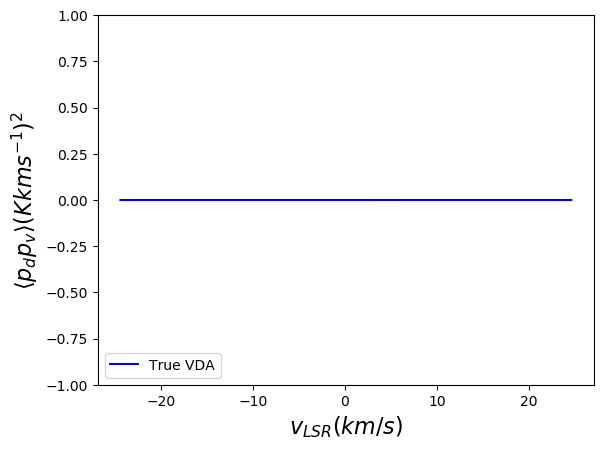

(-1, 1)

In [10]:
plot(v,aa,label="True VDA",color="b")
xlabel(L"$v_{LSR} (km/s)$",fontsize=16)
ylabel(L"$\langle p_d p_v \rangle (K km s^{-1})^2$",fontsize=16)
legend(loc=3)
ylim(-1,1)

This result is significantly different from what Kalberla et.al (2022) claimed. Why? We can have some hints by looking at the `imshow` of the image by turning on the colorbar. For display purpose we only show $p_d$ with native colorbar:


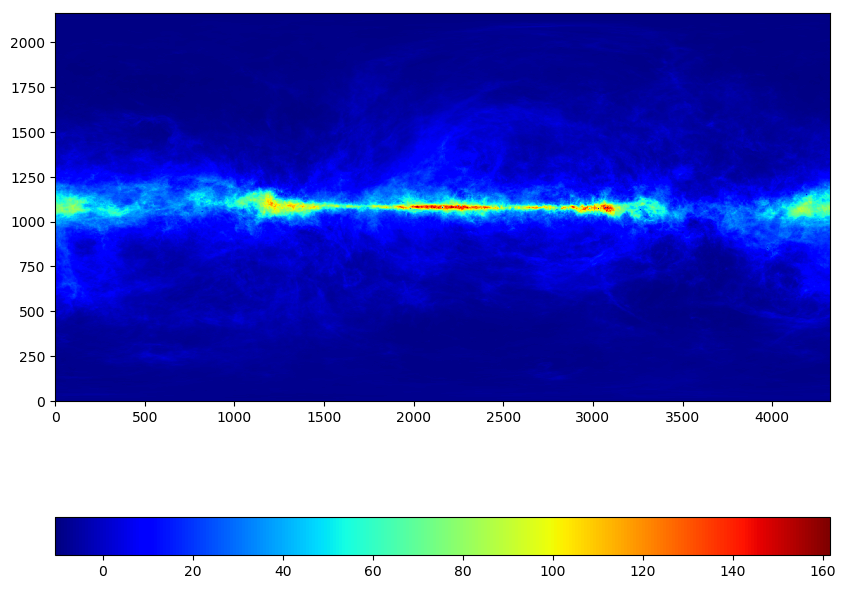

(-10.608749389648438, 161.64532470703125)

In [11]:
figure(figsize=(10,10))
imshow(pd[:,:,v_loc[1]]',cmap="jet",origin="xy")
colorbar(orientation="horizontal")
minimum(pd[:,:,v_loc[1]]),maximum(pd[:,:,v_loc[1]])

We can see from the range of the colorbar that our $p_d$ lies between $[-10.6,161.6]$. This is significantly different from what Fig.1 of Kalberla et.al (2022) displayed $[-134, 12.6]$. Why? They claimed to use the same Eq.(20) from Yuen et.al (2021) and that should _reproduce_ the results above. Notice that the projections, smoothing, and lack of high resolution channel map would not make $\langle p_d p_v\rangle$ change from $0$ to something like $-500$ as displayed in Kalberla et.al (2022). So what is the reason behind?

## Reverse engineering the actual VDA formula that Kalberla et.al (2022) used

$p_d$ has a very simple functional form. To make it from something positive to something very negative, one has to overly subtract something in the numerical implementations of VDA. Notice that $p_d$ is given by:


$$
  p_d = \left( \langle pI\rangle-\langle p\rangle\langle I \rangle\right)\frac{I-\langle I\rangle}{\sigma_I^2}
 $$

If we assume that Kalberla et.al (2022) actually missed some term above, the natural candidate is the following. The reasoning here is that $p<I$ for all selected $p$.

$$
\begin{align}
  p_{d,kalberla} = \left( \langle p\rangle-\langle p\rangle\langle I \rangle\right)\frac{I-\langle I\rangle}{\sigma_I^2}
\end{align}
$$

These three quantites are reasonable typo in the code that will make the expected value of $p_d$ being smaller than expected. To check which one is more correct, we simply check the ranges of the equation above:

In [12]:
function pd_guess(p1,I)
    return (mean(p1).-mean(p1)*mean(I)).*(I.-mean(I))/std(I)^2
end


pd_guess (generic function with 1 method)

In [13]:
# This is the true range for $p_d$
minimum(pd[:,:,v_loc[1]]),maximum(pd[:,:,v_loc[1]])

(-10.608749389648438, 161.64532470703125)

In [14]:
minimum(pd_guess(p[:,:,v_loc[1]],I)),maximum(pd_guess(p[:,:,v_loc[1]],I))

(-98.22429f0, 6.44644f0)

We can see from here that our candidate equation that has very close range to $[-131,12]$ as displayed in Fig.1 bottom left of Kalberla et.al (2022). To illustrate its goodness, we `imshow` the guesses (notice the approximations that we took above, having some shift is rather normal):

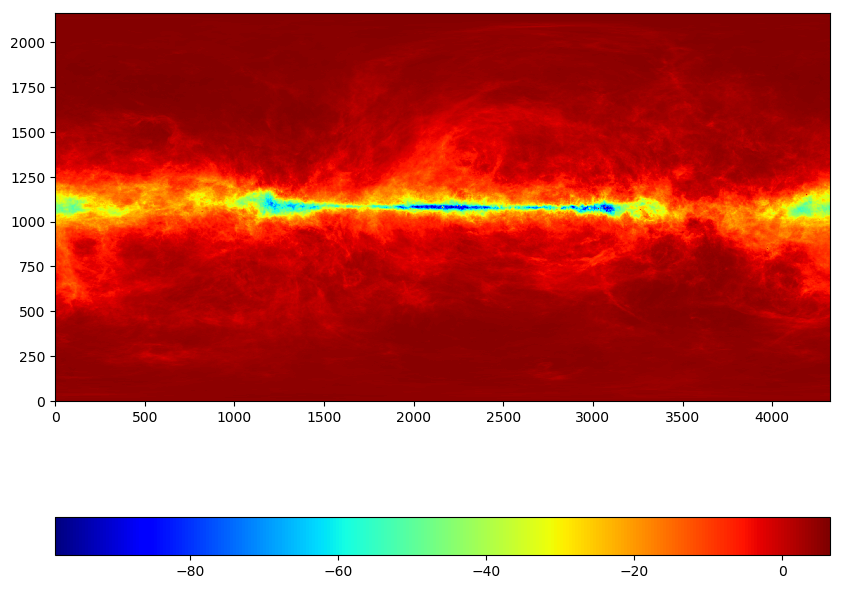

PyObject <matplotlib.colorbar.Colorbar object at 0x7f14c490dc90>

In [15]:
figure(figsize=(10,10))
imshow(pd_guess(p[:,:,v_loc[1]],I)',cmap="jet",origin="xy")
colorbar(orientation="horizontal")

Let us include also the corresponding $p_{v,guess}$ and compute $\langle p_d p_v \rangle$

In [16]:
function pv_guess(p1,I)
    return p1 .- (mean(p1).-mean(p1)*mean(I)).*(I.-mean(I))/std(I)^2
end

pv_guess (generic function with 1 method)

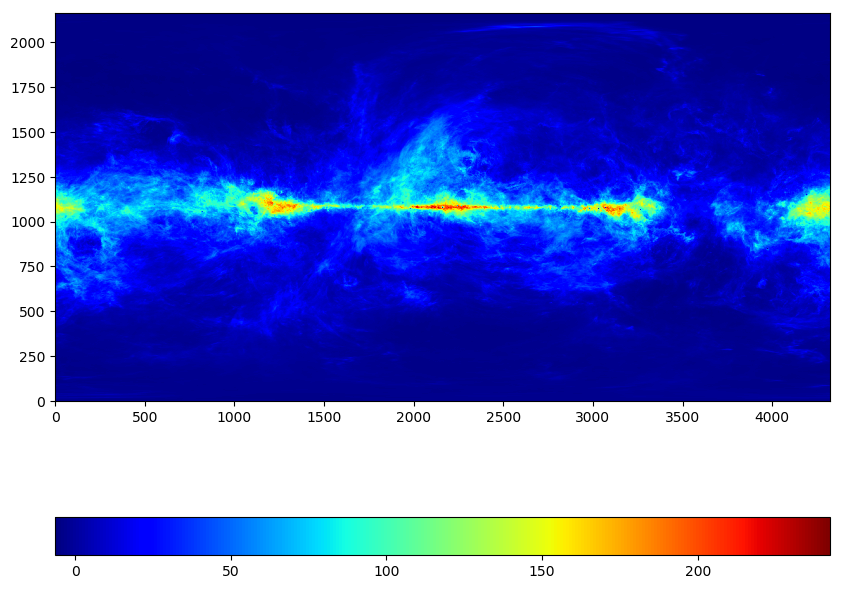

PyObject <matplotlib.colorbar.Colorbar object at 0x7f14c4843fd0>

In [17]:
figure(figsize=(10,10))
imshow(pv_guess(p[:,:,v_loc[1]],I)',cmap="jet",origin="xy")
colorbar(orientation="horizontal")

In [18]:
p_d_kalberla=pd_guess(p[:,:,v_loc[1]],I)';
p_v_kalberla=pv_guess(p[:,:,v_loc[1]],I)';

### And we have our results

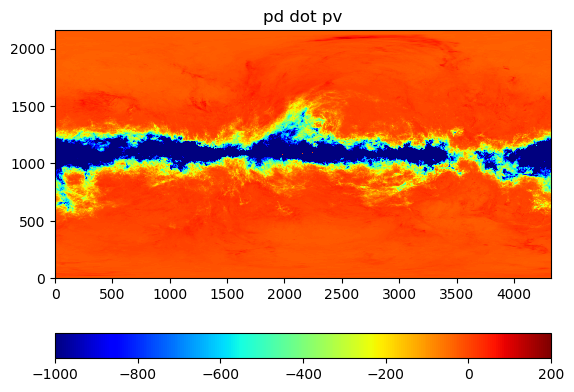

PyObject <matplotlib.colorbar.Colorbar object at 0x7f14bdf65610>

In [19]:
imshow((p_d_kalberla.*p_v_kalberla),vmin=-1e3,vmax=200,cmap="jet",origin="xy")
title("pd dot pv")
colorbar(orientation="horizontal")

In [20]:
aa=zeros(0)
bb=zeros(0)

for i in 1:size(p)[3]
    push!(aa,mean(pd[:,:,i].*pv[:,:,i]))
    p1=p[:,:,i];
    p_d_kalberla=pd_guess(p1,I)';
    p_v_kalberla=pv_guess(p1,I)';
    push!(bb,mean(p_d_kalberla.*p_v_kalberla))
end

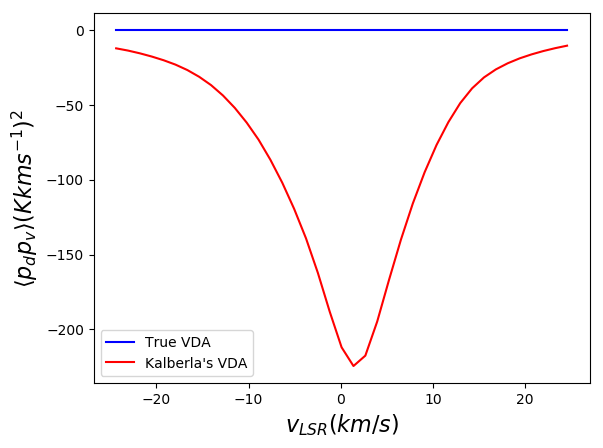

PyObject <matplotlib.legend.Legend object at 0x7f14bdef54d0>

In [21]:
plot(v,aa,label="True VDA",color="b")
plot(v,bb,label="Kalberla's VDA",color="r")
xlabel(L"$v_{LSR} (km/s)$",fontsize=16)
ylabel(L"$\langle p_d p_v \rangle (K km s^{-1})^2$",fontsize=16)
legend(loc=3)

## Conclusion

Upon here readers should agree with us that Kalberla et.al (2022) is very likely using a wrong implementation of VDA (Yuen et.al 2021). We have to remind our readers here that what approximations we made (due to convenience of our preparation):
- We use cartesian projection
- We truncate our cubes to $|v|<25km/s$
- We only have cubes with $\Delta v=1.29 km/s$, and we only found channal at $v=1.389 km/s$ from public data. 
- We perform incomplete line integration of the intensity value $I_{here} = \int_{v=-25 km/s}^{v=25 km/s} dv p(X,v)$.
- We have no noise tackling method, no smoothing, and did not consider any geometry distortion due to projection effect.

However, despite all these problems, we successfully show that
- $\langle p_d p_v\rangle$ under the current VDA implentation (github:kyuen2/LazDDA.jl) is strictly zero
- Kalberla et.al (2022)'s result is likely due to a programmatic error as we produce very similar results to their Fig.1 and 2, despite the amplitudes are different likely due to the reasons above.
- **We here urge the authors of Kalberla et.al (2022) to check their code before publishing anything, especially if one is trying to make serious claims to others' work**